# Replication of Blanchard and Quah AER 1989


In [2]:
import pandas as pd
import os
import numpy as np
from numpy.linalg import inv, multi_dot
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import root
from scipy.io import loadmat
from scipy import signal

In [3]:
#Downloading and preparing data
from pandas_datareader.data import DataReader            
start = '1948Q1'                                              
end = '1987Q3'
#Data from FRED
gdp = DataReader('GNPC96', 'fred',start=start, end=end)
urate = DataReader('UNRATE', 'fred', start=start, end=end)
#Frequency change for urate
urateq = urate.groupby(pd.PeriodIndex(urate.index, freq='Q'), axis=0).mean()
#From YYYYQ format to date format
gdp.index=pd.date_range(start,'1987Q4',freq="Q")
urateq.index=pd.date_range(start,'1987Q4',freq="Q")
#create Frame
df = pd.concat((urateq, gdp), axis=1)
df.columns = ["urate","gdp"]
df["lngdp"] = np.log(df["gdp"])
df["dy"] = (df["lngdp"] - df["lngdp"].shift(1))*400 #annualized quarterly GDP growth
df = df[1:]

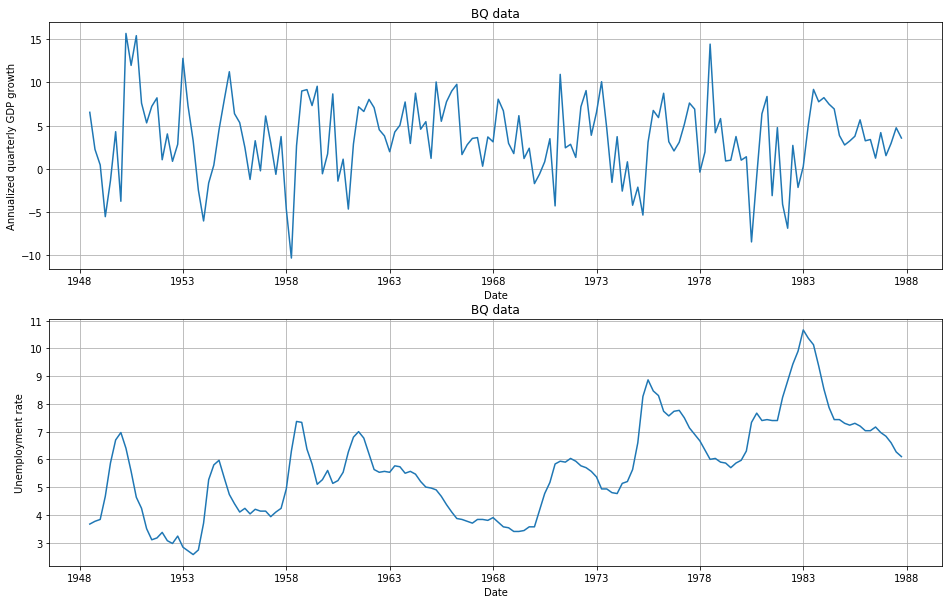

In [4]:
# Plot data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(df["dy"])
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(df["urate"])
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()


In [5]:
#Detrending as in the paper: Important
# Productivity Slowdown less apparent than in origal data, upward trend in urate present
df.loc[:"1973Q2","dys"] = signal.detrend(df.loc[:"1973Q2","dy"],type="constant")
df.loc["1973Q3":,"dys"] = signal.detrend(df.loc["1973Q3":,"dy"],type="constant")
df["urates"] = signal.detrend(df["urate"])

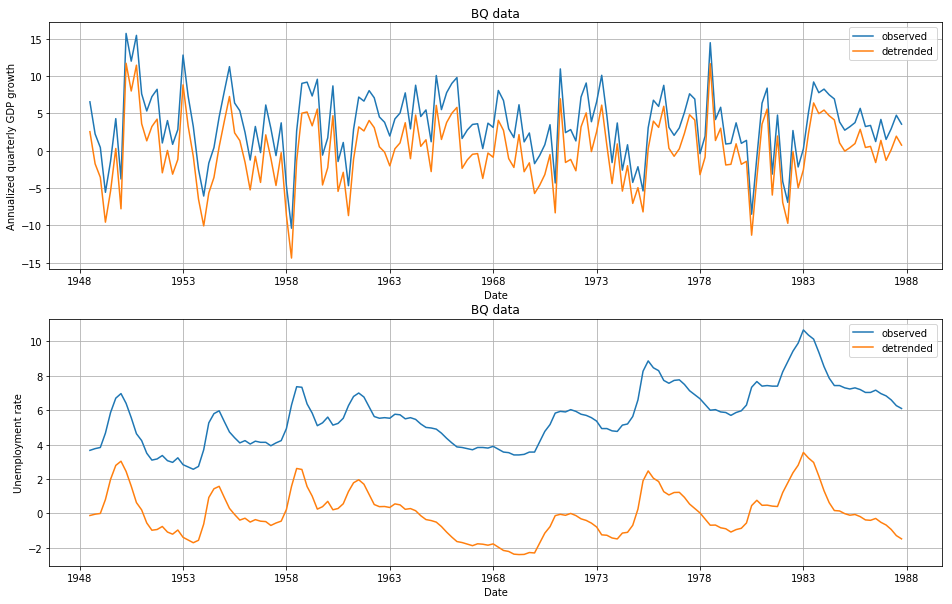

In [6]:
# Plot original data & detrended data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(df['dy'],label='observed')
plt.plot(df['dys'],label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(df['urate'],label='observed')
plt.plot(df['urates'],label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()

In [7]:
#Setting up the data for VAR
X = df.loc[:,["dys","urates"]]

In [8]:
# We can use a statistical package statsmodel
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
# this creates a model VAR which has a lot of methos availabe for example fit
model = VAR(X)
results = model.fit(8,trend='nc')
results.summary()

/Users/franci/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Apr, 2018
Time:                     11:46:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.526240
Nobs:                     150.000    HQIC:                  0.144905
Log likelihood:          -384.979    FPE:                   0.891902
AIC:                    -0.116029    Det(Omega_mle):        0.728255
--------------------------------------------------------------------
Results for equation dys
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
L1.dys            0.076654         0.114306            0.671           0.504
L1.urates        -3.444957         1.427949           -2.413           0.017
L2.dys            0.069675         0.118439            0.588           0.557
L

You should run battery of tests to be sure your specifiaction is correct
$$FPE=\left|\Omega\right|\left(\frac{T+Kp+1}{T+Kp-1}\right)^{K}$$
$$AIC=-2\left(\frac{\mathcal{L}}{T}\right)+2\frac{t_{p}}{T}$$
$$SBIC=-2\left(\frac{\mathcal{L}}{T}\right)+2\frac{ln(T)}{T}t_{p}$$
$$HQIC=-2\left(\frac{\mathcal{L}}{T}\right)+\frac{2ln(ln(T))}{T}t_{p}$$



In [9]:
# for example for lag selection
model.select_order(16)
#the formulas are different as they use the fact that loglikehood is related to determinant
AIC = -2*(-384.979/150) +2*32/150
AIC 
AIC2 = AIC -2*np.log(2*np.pi)-2  # relation with statsmodel formula
AIC2

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         3.426        3.468        30.76        3.443
1      -0.08222      0.04267       0.9211     -0.03147
2       -0.2085  -0.0003749*       0.8118     -0.1239*
3      -0.2195*      0.07192      0.8031*      -0.1011
4       -0.1917       0.1830       0.8259     -0.03941
5       -0.1552       0.3027       0.8568      0.03088
6       -0.1679       0.3733       0.8463      0.05200
7       -0.1160       0.5084       0.8919       0.1377
8      -0.07238       0.6354       0.9323       0.2152
9      -0.09148       0.6995       0.9155       0.2299
10     -0.08208       0.7922       0.9252       0.2732
11     -0.09757       0.8600       0.9123       0.2915
12      -0.1072       0.9336       0.9050       0.3157
13      -0.1091        1.015       0.9051       0.3477
14     -0.06601        1.141       0.9471       0.4246
15     -0.

-0.11603413281869113

## Reduced form VAR code
x(t)=Ahat(1)*x(t-1) + Ahat(2)*x(t-2) + .. + eps(t)

where Ahat(i) is a k*k matrix of coefficients.

In matrix format, this is:

X = X(-1)*Ahat(1)' + X(-2)*Ahat(2)' + .. + EPS 

where X is n_obs*n_vars matrix of data. 

We use:

X = XLAG*Ahat' + EPS

where Ahat = [ Ahat(1) , Ahat(2) ... , Ahat(n_lags) ]

If there are n_lag lags and n_var variables, then Ahat is a 
matrix n_vars*n_vars * n_lags because XLAG has size n_obs*(n_vars*n_lags). 
Note that we do not put a constant since the variabes are detrended 
(so have mean 0 over the sample period)


In [10]:
#let us construct the matrix of lags
XLAG = pd.DataFrame()
num_lags = 8 
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)
#change names to frames that we modify    
X2 = X.iloc[num_lags:,:]
XLAG2 = XLAG.iloc[num_lags:,:]
num_vars = X2.shape[1]
num_obs = XLAG2.shape[0]
#Building arrays for using OLS
X3 = np.array(X2)
XLAG3 = np.array(XLAG2)
#VAR - standard OLS
Ahat = multi_dot([inv(np.dot(XLAG3.T,XLAG3)),XLAG3.T,X3])

Now let us apply our identification restrictions to the covariance matrix of the estimated innovations $v=A(0)\epsilon$
1. $\epsilon\epsilon'=I$ therefore $\Omega=A(0)A(0)'$, gives us three restrictions
2. $LR_{11}=0$ where $LR=(I+C(1)+C(2)+...)A(0)=(I-C)^{-1}A(0)$, gives us one restriction

In [11]:
#Estimated errors
EPS = (X3-np.dot(XLAG3,Ahat))
#estimated covariance matrix
Vhat = np.dot(EPS.T,EPS)/(num_obs - num_lags*num_vars)
#Putting problem in canonical form, temporary arrays just for readability
# c_x(t) = c_Ahat*c_x(t-1) + c_G*eta(t)
# c_Ahat = [ Ahat ; eye((n_lags-1)*n_vars) zeros((n_lags-1)*n_vars,n_vars) ] ;
c_Ahat = np.vstack((Ahat.T,np.hstack((np.identity((num_lags-1)*num_vars),np.zeros([(num_lags-1)*num_vars,num_vars]))))) 

#Setting up for LR restriction
c_Mhat = inv(np.identity(c_Ahat.shape[0])-c_Ahat)
Mhat = c_Mhat[:2,:2]

In [12]:
def objective(x0,Mhat,Vhat,num_vars): #objective function, starts with x0, outputs H, which it uses again as x0 until convergence
        G = np.reshape(x0,[num_vars,num_vars]) #grab starting values, and create a possible matrix G, or A(0)
        LR = np.dot(Mhat,G) #LR effect given by multiplication of Mhat and G
        H = np.dot(G,G.T) - Vhat #G is supposed to be A(0), hence A(0)*A(0).T should be equal to Vhat, as variance of shocks is identity
        H[0,1] = LR[0,1] #However, we add LR restriction
        H = H.flatten()
        return H #each parameter in H must be equal to 0, including LR restriction

In [13]:
x0 = ((Vhat**2)**.25).flatten() #Starting values, flatten is needed for root function below
#returns the values of G, A(0), which guarantee LR restriction = 0, as well as the information from variance-covariance matrix
sol = root(objective,x0,args=(Mhat,Vhat,num_vars)) # Solves F(X) = 0, where both X and 0 can be vectors
G = sol.x.reshape([num_vars,num_vars]) 
A0 = G
#the first shock (supply) should have a positive impact on output (only redefines direction, and changes nothing)
if G[0,0] < 0: G[:,0] = -G[:,0]

#the second shock (demand) should have a positive impact on output (only redefines direction, and changes nothing)
if G[0,1] < 0: G[:,1] = -G[:,1]

#Estimating structural shocks, ETA, as per 6/13, Class4
F = inv(G)
ETA = np.dot(EPS,F.T)

We can now compute the IRF
$$\hat{X}_{t+s}=\sum_{i=0}^{s-1}C_{i}A(0)\epsilon_{t+s-i}$$
define $$\Psi_{i}=\left[\left(C\right)^{i}A(0)\right]$$
you want to study $$\frac{\partial\hat{X}_{t+s}}{\partial\epsilon_{t}}=\Psi_{s}$$

In [14]:
#IRFs
'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock. IRF_sum gives the integrated
    responses (i.e, in levels). IRF_sum(:,1,1) gives the cumulative impulse
    response of variable 1 to shock 1.'''
    
num_impulses = 40
IRF = np.zeros([num_impulses,num_vars,num_vars])
Temp = np.identity(c_Ahat.shape[0])

psi = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = np.dot(psi_t,G) # store the IRF
    Temp = np.dot(c_Ahat,Temp)   # computes the exponent of the matrix
    #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

irf = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
irf.columns = ["s_y","d_y","s_u","d_u"]
irf_cum = irf.cumsum() #output is expressed cumulatively

irf_final = pd.concat([irf_cum["s_y"], #supply shock on output
                        irf_cum["d_y"], #demand shock on output
                        irf["s_u"], #supply shock on unemployment
                        irf["d_u"]],axis=1) #demand shock on unemployment

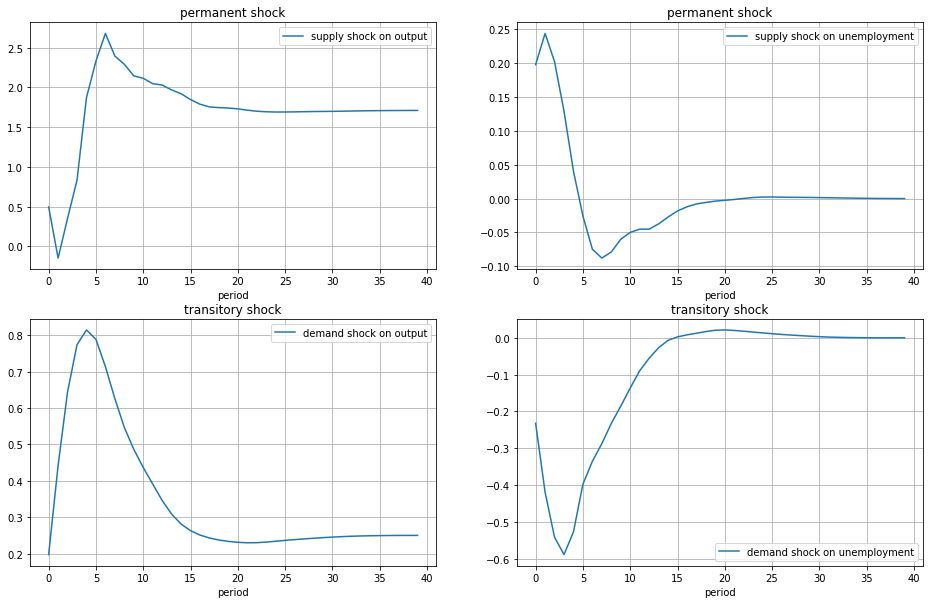

In [15]:
# Plot
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(irf_cum["s_y"],label='supply shock on output')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(222)
plt.plot(irf["s_u"],label='supply shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(223)
plt.plot(irf_cum["s_u"],label='demand shock on output')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.subplot(224)
plt.plot(irf["d_u"],label='demand shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.show()

Variance decomposition
$$FEV^{D}=E_{t_{0}}\left[\left(X_{t_{0}+s}-\widehat{X}_{t_{0}+s}\right)\left(X_{t_{0}+s}-\widehat{X}_{t_{0}+s}\right)^{\prime}\right]=\sum_{t=0}^{s-1}C_{t}\Omega C_{t}^{\prime}$$
$$\Omega=AA^{\prime}=\sum_{j=1}^{n_{vars}}a_{j}a_{j}^{\prime}$$

In [16]:
# variance decomposition 
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = G[:,:1] 
g2 = G[:,1:2] 
Temp = np.identity(c_Ahat.shape[0])               # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t +  np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_D[t,:,:] = MSE1_t 
    MSE2_D[t,:,:] = MSE2_t 
    Temp = np.dot(c_Ahat,Temp)

Vfrac_D1 = MSE1_D/(MSE1_D+MSE2_D)
Vfrac_D2 =MSE2_D/(MSE1_D+MSE2_D)


In [17]:
vfrac_D1 = pd.DataFrame({i:Vfrac_D1[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D1.columns = ["vs_dy","","","vs_u"]
vfrac_D1_final = pd.concat([vfrac_D1["vs_dy"],        #supply shock on variance of growth of output
                           vfrac_D1["vs_u"]],axis=1) #supply shock on variance of unemployment

In [18]:
vfrac_D2 = pd.DataFrame({i:Vfrac_D2[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D2.columns = ["vd_dy","","","vd_u"]
vfrac_D2_final = pd.concat([vfrac_D2["vd_dy"],       #demand shock on variance of growth of output
                           vfrac_D2["vd_u"]],axis=1) #demand shock on variance of unemployment
vfrac_final=pd.concat([vfrac_D1["vs_dy"], vfrac_D1["vs_u"],
                      vfrac_D2["vd_dy"],vfrac_D2["vd_u"]],axis=1)

In [19]:
vfrac_final   

,vs_dy,vs_u,vd_dy,vd_u
0,0.017356,0.421015,0.982644,0.578985
1,0.041899,0.301175,0.958101,0.698825
2,0.056721,0.211261,0.943279,0.788739
3,0.069872,0.152842,0.930128,0.847158
4,0.124145,0.121404,0.875855,0.878596
5,0.128661,0.108705,0.871339,0.891295
6,0.131430,0.104133,0.868570,0.895867
7,0.132783,0.103132,0.867217,0.896868
8,0.132351,0.103139,0.867649,0.896861
9,0.132798,0.102957,0.867202,0.897043


In [20]:
# variance decomposition 
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = G[:,:1] 
g2 = G[:,1:2] 
Temp = np.identity(c_Ahat.shape[0])               # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t +  np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_L[t,:,:] = MSE1_t 
    MSE2_L[t,:,:] = MSE2_t 
    Temp = np.identity(c_Ahat.shape[0]) + np.dot(c_Ahat,Temp)

Vfrac_L1 = MSE1_L/(MSE1_L+MSE2_L)
Vfrac_L2 =MSE2_L/(MSE1_L+MSE2_L)


In [21]:
vfrac_L1 = pd.DataFrame({i:Vfrac_L1[i].flatten() for i in range(num_impulses)}).T #save vardec into dataframe
vfrac_L1.columns = ["vs_y","","",""]
vfrac_L1_final = vfrac_L1["vs_y"] #supply shock on variance of output
                         
vfrac_L2 = pd.DataFrame({i:Vfrac_L2[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
vfrac_L2.columns = ["vd_y","","",""]
vfrac_L2_final = vfrac_L2["vd_y"] #demand shock on on variance of output
                          
vfrac_final_L=pd.concat([vfrac_L1["vs_y"],vfrac_L2["vd_y"]],axis=1)

In [22]:
vfrac_final_L

,vs_y,vd_y
0,0.017356,0.982644
1,0.007161,0.992839
2,0.006254,0.993746
3,0.012576,0.987424
4,0.043149,0.956851
5,0.082159,0.917841
6,0.126752,0.873248
7,0.157776,0.842224
8,0.183952,0.816048
9,0.205395,0.794605


In [23]:
G_hat = np.vstack((G,np.zeros([(num_lags-1)*num_vars,num_vars])))

In [24]:
# simulation
#shut down a shock
ETA_D = ETA.copy()
ETA_D[:,0]=np.zeros((num_obs))
ETA_S = ETA.copy()
ETA_S[:,1]=np.zeros((num_obs))
X_sim=np.zeros([num_vars,num_lags])
for i in range(num_lags):
    X_sim[:,num_lags-1-i]=X.iloc[i,:]
X_sim=np.reshape(X_sim,(num_lags*num_vars,1),order='F')
X_sim = np.hstack((X_sim,np.zeros([num_lags*num_vars,num_obs-1])))
X_sim_D = X_sim.copy()
X_sim_S = X_sim.copy()
for t in range(num_obs-num_lags):
    X_sim[:,t+1] = np.dot(c_Ahat,X_sim[:,t]) + np.dot(G_hat,ETA.T[:,t])
    X_sim_D[:,t+1] = np.dot(c_Ahat,X_sim_D[:,t]) + np.dot(G_hat,ETA_D.T[:,t])
    X_sim_S[:,t+1] = np.dot(c_Ahat,X_sim_S[:,t]) + np.dot(G_hat,ETA_S.T[:,t])


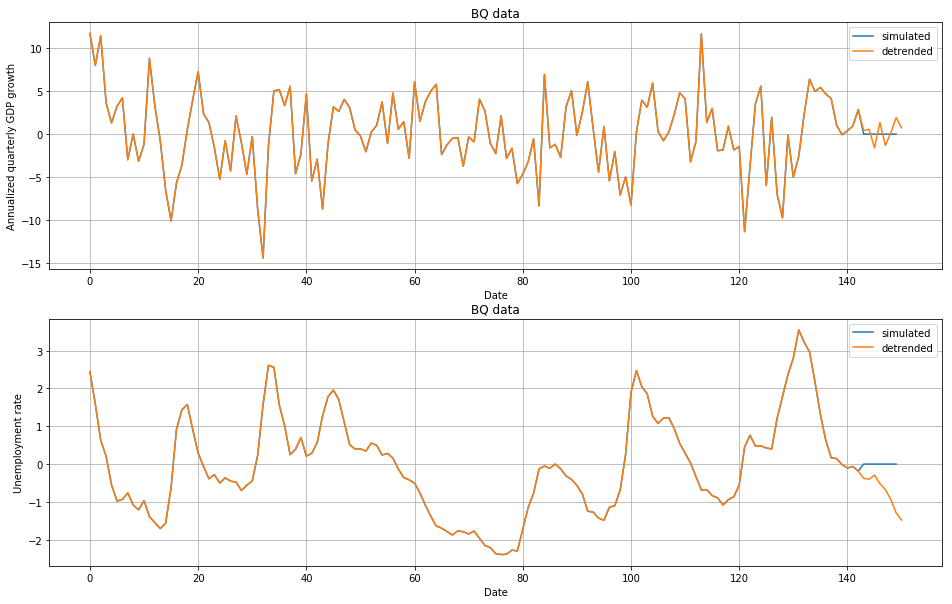

In [25]:

# Plot original data & simulated data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(X_sim[0,:],label='simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(X_sim[1,:],label='simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()


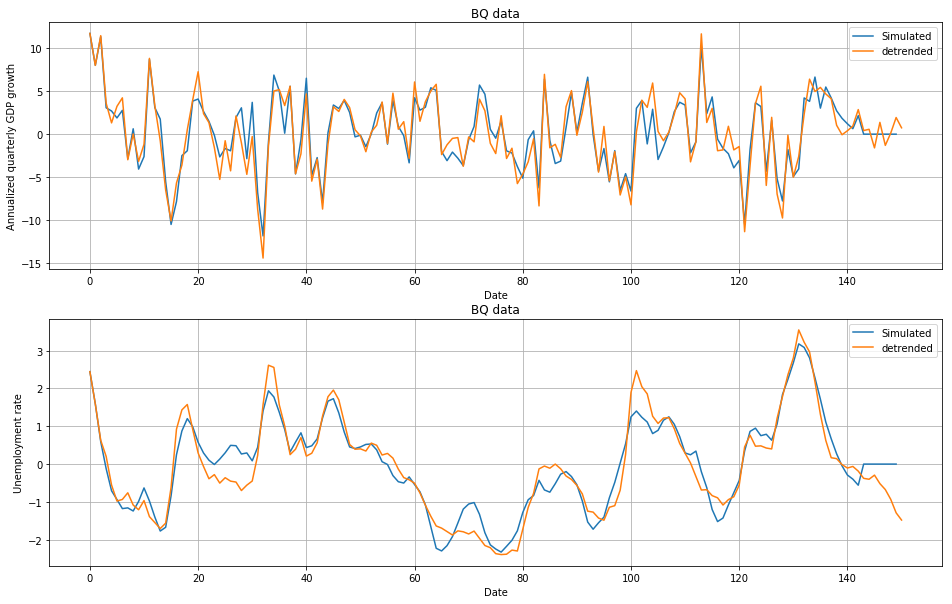

In [26]:

# Plot original data & simulated data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(X_sim_D[0,:],label='Simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(X_sim_D[1,:],label='Simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()



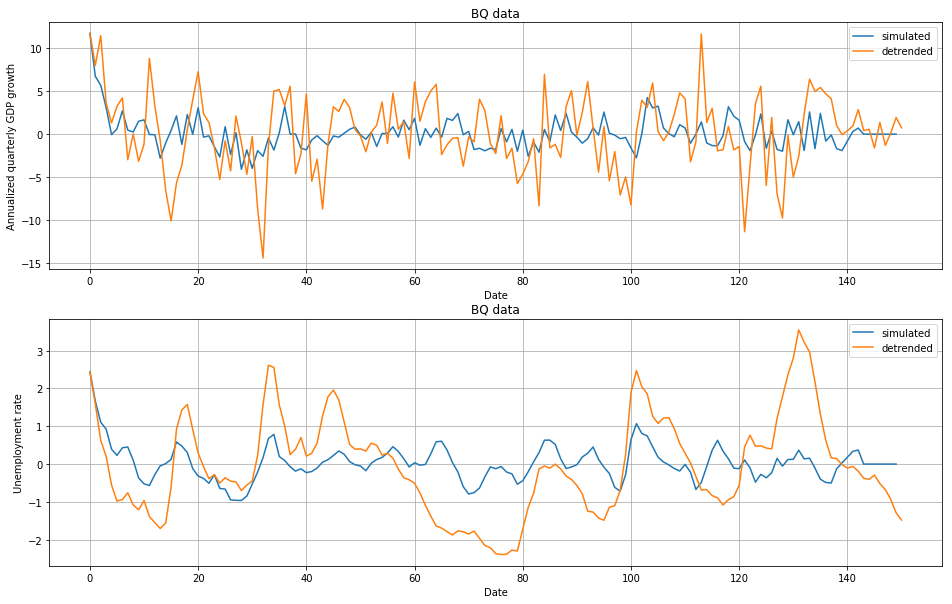

In [27]:

# Plot original data & simulated data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(X_sim_S[0,:],label='simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(X_sim_S[1,:],label='simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()